In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from epam.dnsm import TransformerBinarySelectionModel, DNSMBurrito
from epam.sequences import translate_sequences

In [2]:
pcp_df = pd.read_csv("~/data/wyatt-10x-1p5m_pcp_2023-10-07.mimic-only_allow_mutations_next_to_hydrophobic_sites.csv")

# filter out rows of pcp_df where the parent and child sequences are identical
pcp_df = pcp_df[pcp_df["parent"] != pcp_df["child"]]

# NOTE downsampling here
pcp_df = pcp_df.sample(5000, random_state=42)

print(f"We have {len(pcp_df)} PCPs.")

We have 5000 PCPs.


In [3]:
shmple_weights_directory = "/Users/matsen/re/epam/data/shmple_weights/my_shmoof"
nhead = 2
dim_feedforward = 2048
layer_count = 2

dnsm = TransformerBinarySelectionModel(
    nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
)

burrito = DNSMBurrito(pcp_df, shmple_weights_directory, dnsm, batch_size=1024, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

Using Metal Performance Shaders
preparing data...


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
predicting mutabilities and substitutions...
consolidating this into substitution probabilities...


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def selection_factor_plot(model):
    parents = pcp_df.reset_index(drop=True)["parent"]
    if len(parents) > 1000:
        parents = parents.sample(1000)
    aa_parents = translate_sequences(parents)
    selection_factor_arrays = [model.selection_factors_of_aa_str(aa_str).cpu().numpy() for aa_str in aa_parents]

    hydrophobic_aas = set(list("AILMFWV"))

    def selection_factor_means(aa_str, selection_factor_array):
        adjacent_hydrophobic_selection_factors = []
        other_selection_factors = []
        
        # Check for each position in the amino acid string
        for i, aa in enumerate(aa_str):
            if aa not in hydrophobic_aas:
                if (i > 0 and aa_str[i-1] in hydrophobic_aas) or \
                   (i < len(aa_str) - 1 and aa_str[i+1] in hydrophobic_aas):
                    # The current amino acid is adjacent to a hydrophobic one
                    adjacent_hydrophobic_selection_factors.append(selection_factor_array[i])
                else:
                    other_selection_factors.append(selection_factor_array[i])
        
        return {
            "adjacent_hydrophobic_selection_mean": np.mean(adjacent_hydrophobic_selection_factors) if adjacent_hydrophobic_selection_factors else np.nan,
            "other_selection_mean": np.mean(other_selection_factors) if other_selection_factors else np.nan
        }

    df = pd.DataFrame([selection_factor_means(aa_str, selection_factor_array) for aa_str, selection_factor_array in zip(aa_parents, selection_factor_arrays)])

    # Scatter plot
    plt.scatter(df['adjacent_hydrophobic_selection_mean'], df['other_selection_mean'], label='sequences', alpha=0.1)
    plt.xlabel('Adjacent Hydrophobic Selection Mean')
    plt.ylabel('Other Selection Mean')

    # Add x=y line
    lims = [
        np.nanmin([plt.xlim(), plt.ylim()]),  
        np.nanmax([plt.xlim(), plt.ylim()]),  
    ]
    plt.plot(lims, lims, 'k--', alpha=0.5, label='x=y line')
    plt.xlim(lims)
    plt.ylim(lims)

    plt.legend()
    plt.show()


In [5]:
burrito.train(15)
burrito.optimize_branch_lengths()
burrito.train(50)
burrito.optimize_branch_lengths()
burrito.train(50)

Epoch [0/15], Training Loss: 0.15902602300047874, Validation Loss: 0.15775974094867706
training model...
Epoch [1/15], Training Loss: 0.14972983300685883, Validation Loss: 0.15728257596492767
Epoch [2/15], Training Loss: 0.1551482230424881, Validation Loss: 0.1558407098054886
Epoch [3/15], Training Loss: 0.15515395998954773, Validation Loss: 0.15570436418056488
Epoch [4/15], Training Loss: 0.16555604338645935, Validation Loss: 0.1557064950466156
Epoch [5/15], Training Loss: 0.16002535820007324, Validation Loss: 0.15543392300605774
Epoch [6/15], Training Loss: 0.15568065643310547, Validation Loss: 0.15547558665275574
Epoch [7/15], Training Loss: 0.15361113846302032, Validation Loss: 0.15541990101337433
Epoch [8/15], Training Loss: 0.15818187594413757, Validation Loss: 0.15525996685028076
Epoch [9/15], Training Loss: 0.15611501038074493, Validation Loss: 0.15513932704925537
Epoch [10/15], Training Loss: 0.15878114104270935, Validation Loss: 0.15500593185424805
Epoch [11/15], Training Los

Finding optimal branch lengths:  57%|█████▋    | 2271/4000 [07:01<04:57,  5.81it/s]

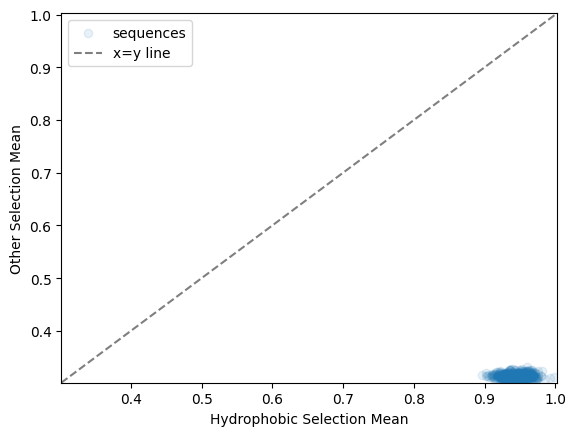

In [ ]:
selection_factor_plot(burrito.dnsm)

In [ ]:
[aa_str] = translate_sequences([pcp_df.reset_index(drop=True).loc[0, "parent"]])
burrito.dnsm.selection_factors_of_aa_str(aa_str)

tensor([0.4154, 0.9990, 0.4920, 0.9990, 0.9990, 0.4669, 0.3004, 0.3085, 0.3659,
        0.6386, 0.9990, 0.3892, 0.3406, 0.2658, 0.3201, 0.9990, 0.3527, 0.9990,
        0.3243, 0.7465, 0.3012, 0.3020, 0.3443, 0.9990, 0.2832, 0.2517, 0.3053,
        0.2429, 0.9990, 0.2432, 0.3244, 0.2771, 0.2467, 0.9990, 0.3504, 0.9990,
        0.7082, 0.2698, 0.3729, 0.9990, 0.2585, 0.2574, 0.4012, 0.2402, 0.8882,
        0.3584, 0.9990, 0.9990, 0.2694, 0.9990, 0.9990, 0.3277, 0.2405, 0.3694,
        0.2434, 0.2635, 0.3047, 0.2508, 0.2414, 0.3444, 0.9990, 0.3899, 0.2540,
        0.9356, 0.2448, 0.2785, 0.3129, 0.9990, 0.4995, 0.7648, 0.2755, 0.9990,
        0.3514, 0.2405, 0.2695, 0.3931, 0.2775, 0.2446, 0.9990, 0.3271, 0.9990,
        0.4036, 0.9990, 0.2844, 0.3031, 0.9990, 0.3507, 0.9990, 0.4135, 0.4005,
        0.2502, 0.9990, 0.9990, 0.3615, 0.3262, 0.2998, 0.9990, 0.3617, 0.3823,
        0.3241, 0.9282, 0.2421, 0.9990, 0.8815, 0.3345, 0.2737, 0.2887, 0.3535,
        0.9990, 0.9990, 0.3970, 0.2707, 

In [ ]:
# nhead = 4
# dim_feedforward = 2048
# layer_count = 3
# 
# model = TransformerBinarySelectionModel(
#     nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
# )
# 
# model.load_state_dict(torch.load("../_trained_dnsms/dnsm-hydrophobic-2023-11-01.pth")["model_state_dict"])
# model.eval()



In [ ]:
# model = TransformerBinarySelectionModel(
#     nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
# )
nobl_trained_dnsm = TransformerBinarySelectionModel(
    nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
)

nobl_trained_burrito = DNSMBurrito(pcp_df, shmple_weights_directory, nobl_trained_dnsm, batch_size=1024, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

nobl_trained_burrito.train(50)

model = nobl_trained_burrito.dnsm


Using Metal Performance Shaders
preparing data...


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
Epoch [0/50], Training Loss: 0.17235839366912842, Validation Loss: 0.18047381937503815
training model...
Epoch [1/50], Training Loss: 0.17263294756412506, Validation Loss: 0.17744286358356476
Epoch [2/50], Training Loss: 0.17027811706066132, Validation Loss: 0.17482522130012512
Epoch [3/50], Training Loss: 0.1694938689470291, Validation Loss: 0.17247436940670013
Epoch [4/50], Training Loss: 0.16828449070453644, Validation Loss: 0.17024457454681396
Epoch [5/50], Training Loss: 0.16738897562026978, Validation Loss: 0.16803215444087982
Epoch [6/50], Training Loss: 0.16614751517772675, Validation Loss: 0.1657996028661728
Epoch [7/50], Training Loss: 0.1646161526441574, Validation Loss: 0.16359853744506836
Epoch [8/50], Training Loss: 0.16424641013145447, Validation Loss: 0.16142292320728302
Epoc

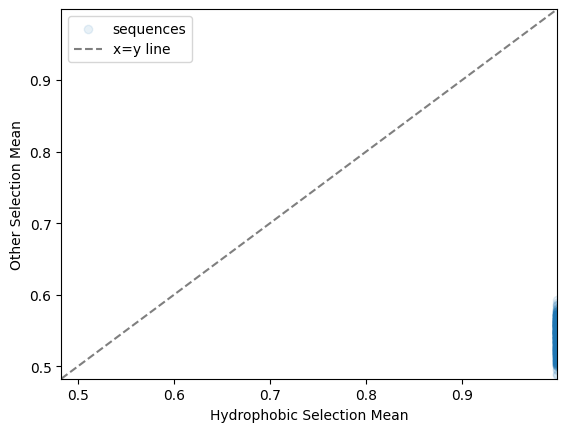

In [ ]:
selection_factor_plot(nobl_trained_burrito.dnsm)